# K-means

## Helper functions

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp
from google.colab import drive
drive.mount('/content/drive')
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(
      input_tensor, reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.log(
      tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keep_dims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

Mounted at /content/drive


## load data and train

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
def load(is_valid,is_2D):
    # Loading data
    if (is_2D):
        data = np.load('/content/drive/My Drive/ECE421/Assignment3/data2D.npy')
    
    else:
        data = np.load('/content/drive/My Drive/ECE421/Assignment3/data100D.npy')
    [num_pts, dim] = np.shape(data)

    # For Validation set
    if is_valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        train_data = data[rnd_idx[valid_batch:]]
        return train_data,val_data
    else:
        return data

# Distance function for K-means
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the squared pairwise distance matrix (NxK)
    
    X = tf.expand_dims(X,1) #shape becomes (N,1,D)
    square = tf.square((X-MU))
    pair_dist = tf.reduce_sum(square,2) #change shape to (N,K)
    return pair_dist
#X = np.matrix([[1,2,3],[1,2,3]]) 
#MU = np.matrix([[1,2,3],[1,2,3],[1,2,3],[1,2,3]]) #K=4,D=3,N=2

In [10]:
def K_means(K,D,epochs,trainset,validset,plot):
    X = tf.placeholder(tf.float64, shape=(None,D))
    MU = tf.Variable(tf.truncated_normal((K, D), mean=0, 
              stddev=1, dtype=tf.float64), trainable=True)
    loss = tf.reduce_sum(tf.reduce_min(distanceFunc(X,MU), axis=1))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, 
                      beta2=0.99, epsilon=1e-5).minimize(loss)

    train_loss = []
    valid_loss = []
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for i in range(epochs):
            session.run([MU,optimizer], feed_dict={X: trainset})
            loss_train = session.run(loss, feed_dict={X: trainset})
            loss_valid = session.run(loss, feed_dict={X: validset})
            train_loss.append(loss_train/trainset.shape[0])
            valid_loss.append(loss_valid/validset.shape[0])
            if (i==epochs-1):
                print("final train_loss is:", loss_train/trainset.shape[0])
                print("final valid_loss is:", loss_valid/validset.shape[0])
        if (plot):
            plt.plot(range(epochs),train_loss,label="training loss")
            plt.legend(loc='best')
            plt.plot(range(epochs),valid_loss,label="validation loss")
            plt.legend(loc='best')
            plt.ylabel('Loss')
            plt.xlabel('Epochs')
            plt.title('Train and Validation Loss', fontsize=16)
            plt.show()
            best_MU = session.run(MU, feed_dict={X: trainset})
            clustering = session.run(tf.argmin(distanceFunc(X, best_MU), 1),
                          feed_dict={X: trainset})
            legend = []
            color = ['c', 'b', 'g', 'r', 'm', 'y', 'k', 'w']
            for i in range(K):
                class_i=[]
                for j in range(len(clustering)):
                    if (clustering[j]==i):
                        class_i.append(trainset[j,:])
                class_i = np.array(class_i)
                plt.scatter(class_i[:, 0], class_i[:, 1], cmap='Pastel')
                legend.append("class"+str(i+1)+"-"
                        +str(100*np.sum(i==clustering)/len(clustering))+"%")
            plt.legend(legend)
            plt.scatter(best_MU[:, 0], best_MU[:, 1], c='black')
            plt.title("K-Means Clustering, valid_loss = %f" %(valid_loss[epochs-1]))
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid()
            plt.show()
    return
 

final train_loss is: 0.523365284615642
final valid_loss is: 0.48914923064022153


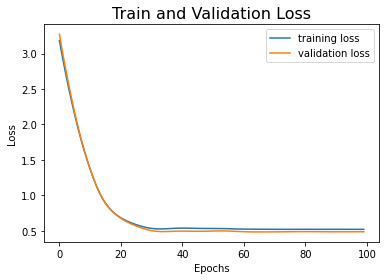

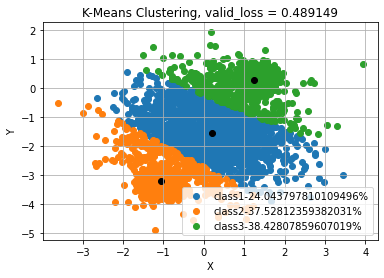

In [12]:
K_means(3,D,100,trainset,validset,1)

final train_loss is: 3.838158532319613
final valid_loss is: 3.861516978605301


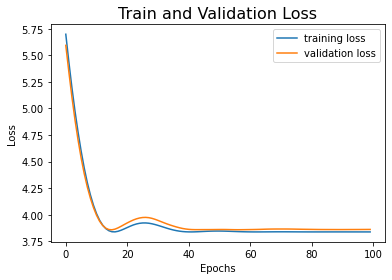

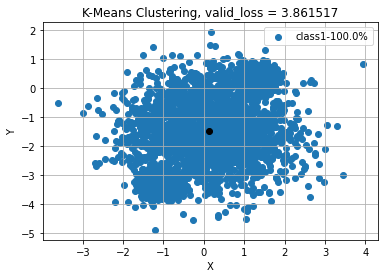

final train_loss is: 0.936674693815796
final valid_loss is: 0.8880614558565628


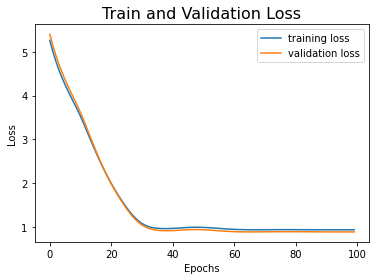

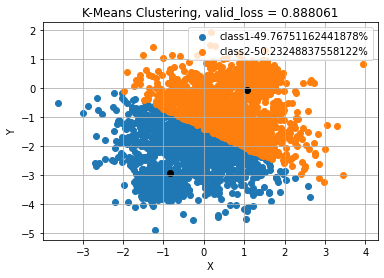

final train_loss is: 0.5234275087907732
final valid_loss is: 0.48841602691863395


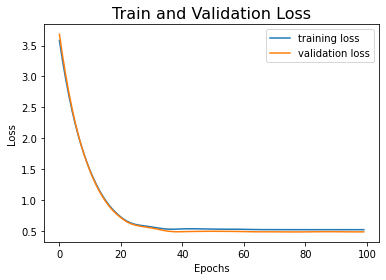

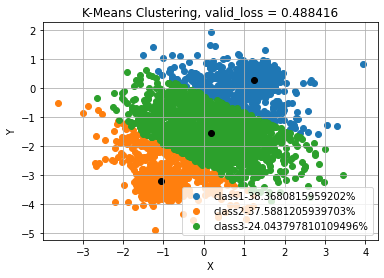

final train_loss is: 0.3481259452719654
final valid_loss is: 0.3165139891972528


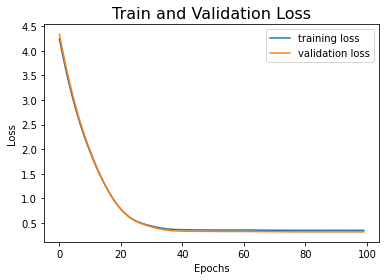

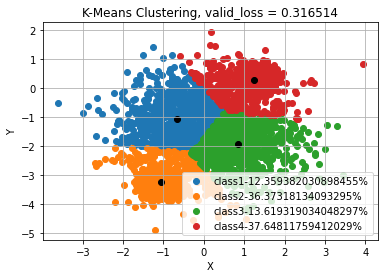

final train_loss is: 0.2941077741786224
final valid_loss is: 0.26658044081666754


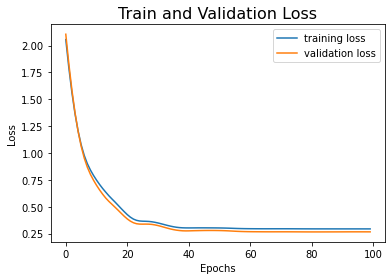

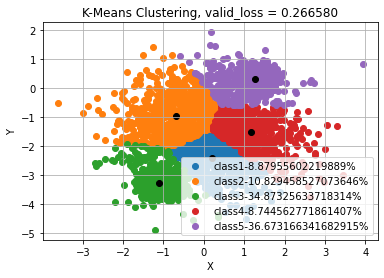

In [11]:
trainset,validset = load(1,1)
D = trainset.shape[1]
for K in [1,2,3,4,5]:
  K_means(K,D,100,trainset,validset,1)

# GMM

In [13]:
# Distance function for GMM
# same as before
import math as m
def log_GaussPDF(X, mu, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K
    '''pair_dist = distanceFunc(X,mu)
    sigma = tf.squeeze(sigma)
    log_1 = -0.5*tf.log((2 * m.pi*tf.square(sigma)))
    log_2 = -0.5*distanceFunc(X,mu)/tf.square(sigma)
    return log_1+log_2
    '''
    constants = -(0.5) * tf.log(2 * np.pi * tf.transpose(sigma)**2)
    pair_dist = distanceFunc(X, mu)
    return constants - tf.square(pair_dist) / (2 * tf.transpose(sigma)**2)

def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K
    
    log_post = log_PDF+ tf.squeeze(log_pi)
    return log_post-reduce_logsumexp(log_post, keep_dims=True)
    

def GMM(K,D,epochs,trainset,validset,plot):
    #define variables
    X = tf.placeholder(tf.float32, shape=(None,D))
    mu = tf.Variable(tf.random_normal([K, D], stddev = 1)) 
    sigma = tf.Variable(tf.random_normal([K, 1], stddev = 1))
    pi = tf.Variable(tf.random_normal([K, 1], stddev = 1))
    sigma = tf.exp(sigma)
    log_pdf = log_GaussPDF(X,mu,sigma)
    log_pi = logsoftmax(pi)
    

    #defien loss & optimizer
    #loss = tf.reduce_sum(log_posterior(log_pdf,log_pi))
    loss= - tf.reduce_sum(reduce_logsumexp(log_pdf + tf.squeeze(log_pi), keep_dims=True))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, 
                      beta2=0.99, epsilon=1e-5).minimize(loss)
    clustering = tf.argmax(log_posterior(log_pdf,log_pi),1)
    train_loss = []
    valid_loss = []
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        for i in range(epochs):
            session.run([optimizer, mu, clustering, sigma, log_pi], feed_dict={X: trainset})
            loss_train = session.run(loss, feed_dict={X: trainset})
            loss_valid = session.run(loss, feed_dict={X: validset})
            train_loss.append(loss_train/trainset.shape[0])
            valid_loss.append(loss_valid/validset.shape[0])
            #print("train_loss at",i,"is:", loss_train/trainset.shape[0])
            if (i==epochs-1):
                print("final train_loss is:", loss_train/trainset.shape[0])
                print("final valid_loss is:", loss_valid/validset.shape[0])
        if (plot):
            plt.plot(range(epochs),train_loss,label="training loss")
            plt.plot(range(epochs),valid_loss,label="validation loss")
            plt.legend(loc='best')
            plt.ylabel('Loss')
            plt.xlabel('Epochs')
            plt.title('Train and Validation Loss', fontsize=16)
            plt.show()
            clustering,mu = session.run([tf.argmax(log_posterior(log_pdf,log_pi),1),mu]
                                        ,feed_dict={X:trainset})
            legend = []
            for i in range(K):
                #print("class",i,"percentage is", np.sum(i==clustering)/len(clustering))
                class_i=[]
                for j in range(len(clustering)):
                    if (clustering[j]==i):
                        class_i.append(trainset[j,:])
                class_i = np.array(class_i)
                if (len(class_i)!=0):
                    plt.scatter(class_i[:, 0], class_i[:, 1])
                    legend.append("class"+str(i+1)+"-"
                    +str(100*np.sum(i==clustering)/len(clustering))+"%")
            plt.legend(legend)

            plt.scatter(mu[:, 0], mu[:, 1], c='red')
            plt.title("K-Means Clustering, valid_loss = %f" %(valid_loss[epochs-1]))
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid()
            plt.show()
    return

final train_loss is: 1.3944799830320984
final valid_loss is: 1.3474461703982898


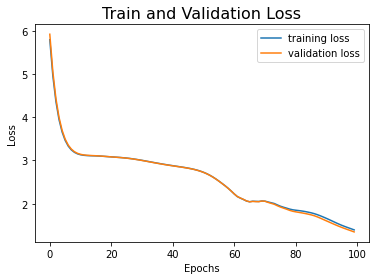

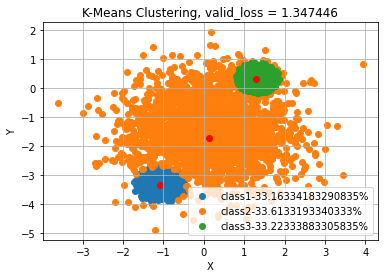

In [17]:
GMM(3,D,100,trainset,validset,1)

final train_loss is: 4.970804780073497
final valid_loss is: 5.036320038253826


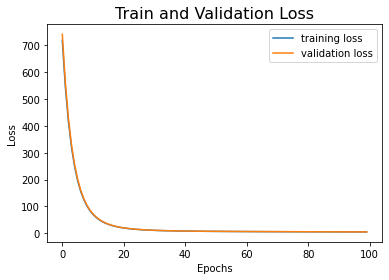

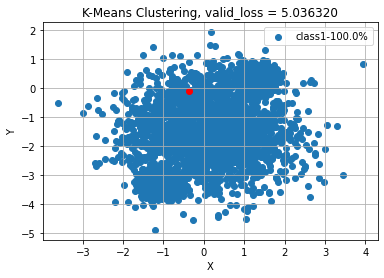

final train_loss is: 2.0471985678059847
final valid_loss is: 2.012926341462271


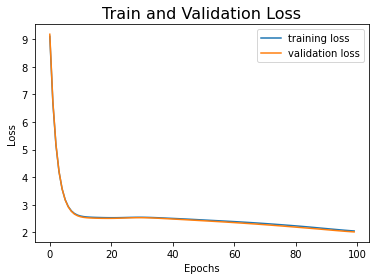

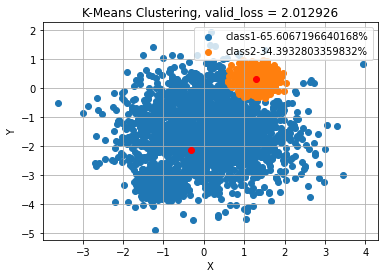

final train_loss is: 1.9329285977107395
final valid_loss is: 1.910898121062106


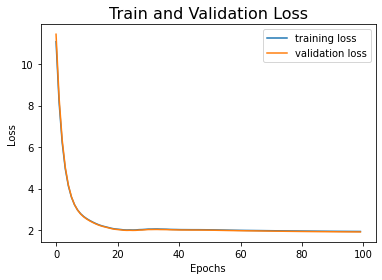

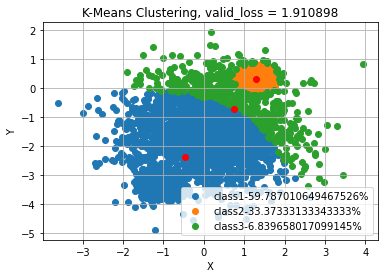

final train_loss is: 1.321762915760462
final valid_loss is: 1.281799957339484


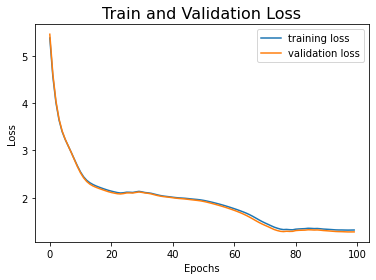

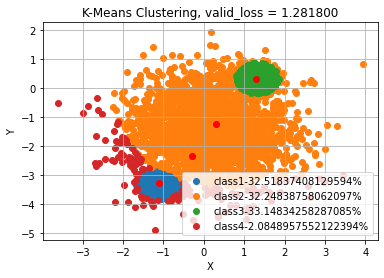

final train_loss is: 1.307434237663117
final valid_loss is: 1.2745344846984699


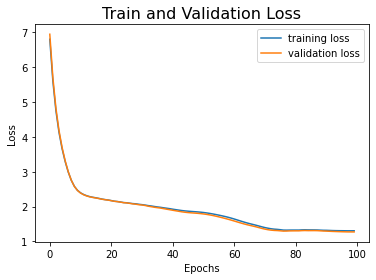

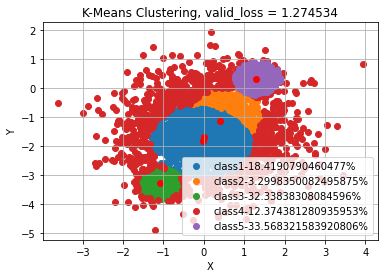

In [28]:
trainset,validset = load(1,1)
D = trainset.shape[1]
for K in [1,2,3,4,5]:
  GMM(K,D,100,trainset,validset,1)

final train_loss is: 2.882789356625919
final valid_loss is: 2.879023449219922


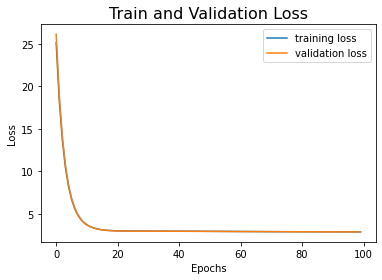

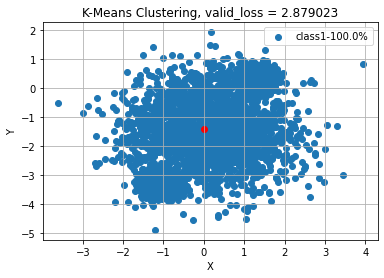

In [30]:
GMM(1,D,100,trainset,validset,1)

final train_loss is: 2.8768245181490926
final valid_loss is: 2.82531544170042


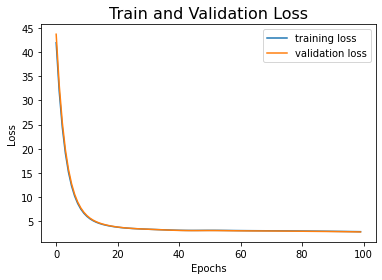

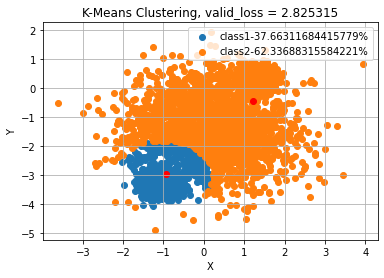

In [31]:
GMM(2,D,100,trainset,validset,1)

final train_loss is: 1.8548829882724613
final valid_loss is: 1.8182733800723823


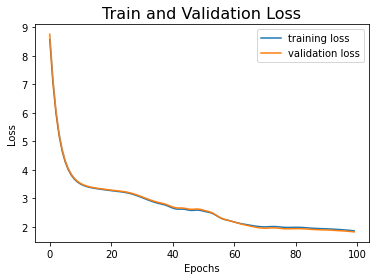

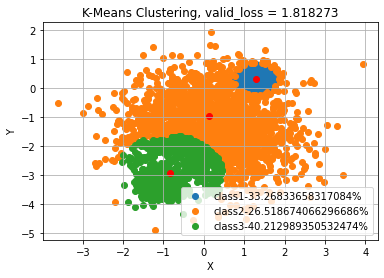

In [32]:
GMM(3,D,100,trainset,validset,1)

final train_loss is: 1.311691300200615
final valid_loss is: 1.284008576638914


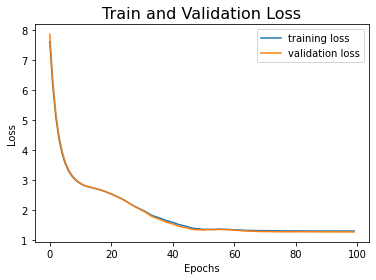

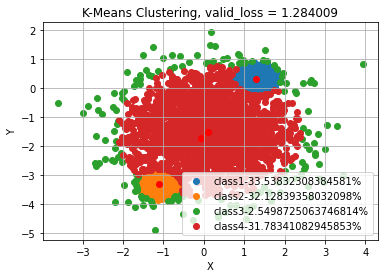

In [35]:
GMM(4,D,100,trainset,validset,1)

final train_loss is: 1.3033699389249287
final valid_loss is: 1.2633797559443445


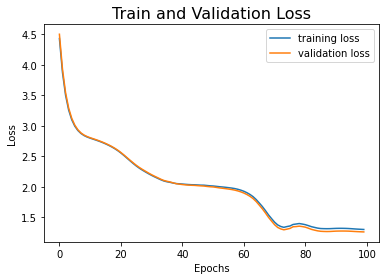

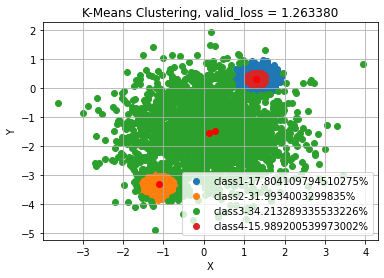

In [36]:
GMM(5,D,100,trainset,validset,1)

final train_loss is: 3.2257231864969254
final valid_loss is: 3.2313184443444345


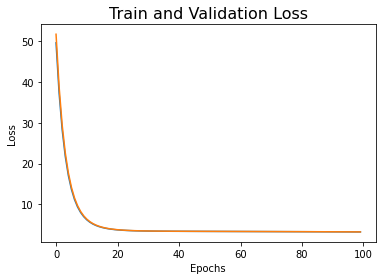

[0 0 0 ... 0 0 0]


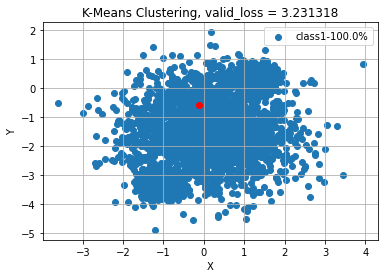

final train_loss is: 2.2434767910041997
final valid_loss is: 2.2056916629162915


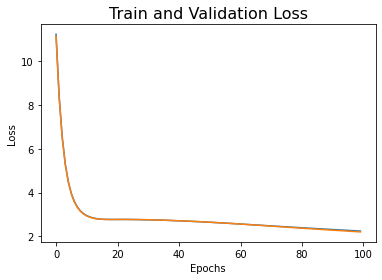

[1 1 1 ... 1 0 1]


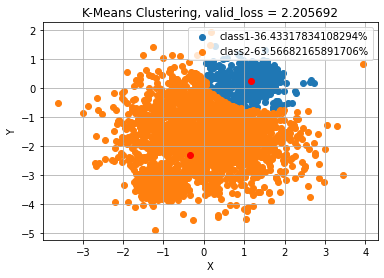

final train_loss is: 1.3273271395023998
final valid_loss is: 1.288012541488524


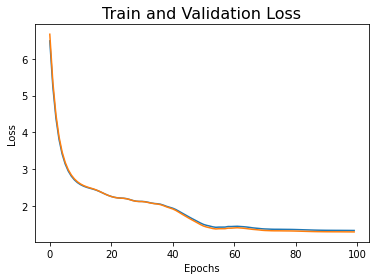

[2 2 1 ... 1 0 1]


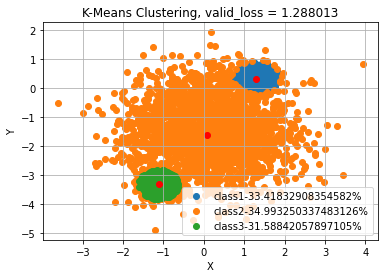

final train_loss is: 1.319217730519724
final valid_loss is: 1.2882192516126614


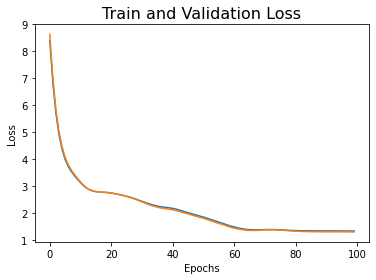

[0 0 2 ... 2 1 2]


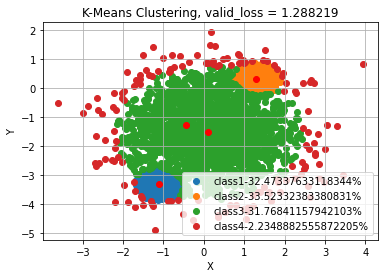

final train_loss is: 1.8783853776061197
final valid_loss is: 1.854331624568707


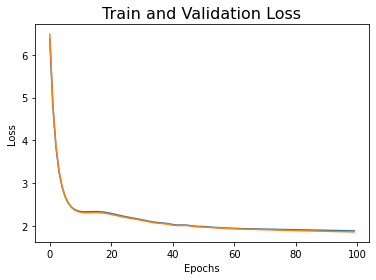

[4 4 4 ... 2 3 1]


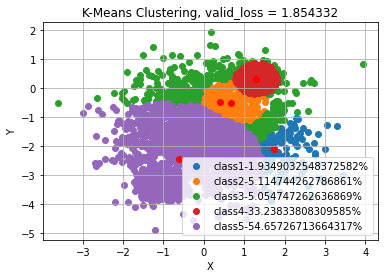

In [ ]:
trainset,validset = load(1,1)
D = trainset.shape[1]
#GMM(3,D,100,trainset,validset,1)
for K in [1,2,3,4,5]:
  GMM(K,D,100,trainset,validset,1)

In [ ]:
trainset,validset = load(1,0)
D = trainset.shape[1]
for k in [5,10,15,20,25,30]:
  print("when K is",k)
  GMM(k,D,100,trainset,validset,0)
for k in [5,10,15,20,25,30]:
  print("when K is",k)
  K_means(K,D,100,trainset,validset,0)

when K is 5
final train_loss is: 13.331976760536973
final valid_loss is: 13.309491496024602
when K is 10
final train_loss is: 13.380509880755962
final valid_loss is: 13.311136973072307
when K is 15
final train_loss is: 7.706893561571921
final valid_loss is: 7.689492972734773
when K is 20
final train_loss is: 8.212946579233538
final valid_loss is: 8.145450091884188
when K is 25
final train_loss is: 7.1394514258662065
final valid_loss is: 7.1397260819831985
when K is 30
final train_loss is: 6.204632541810409
final valid_loss is: 6.197514673342334
when K is 5
final train_loss is: 37.1081341199015
final valid_loss is: 37.34670889328778
when K is 10
final train_loss is: 36.850980373753444
final valid_loss is: 36.817817310988126
when K is 15
final train_loss is: 21.528134613760717
final valid_loss is: 21.542741813519743
when K is 20
final train_loss is: 45.4793234184456
final valid_loss is: 46.21664465572279
when K is 25
final train_loss is: 21.52818844439444
final valid_loss is: 21.54342213

In [ ]:
trainset,validset = load(1,0)
D = trainset.shape[1]
for k in [5,10,15,20,25,30]:
  print("when K is",k)
  K_means(K,D,100,trainset,validset,0)

when K is 5
final train_loss is: 36.88520967246908
final valid_loss is: 37.161319851129754
when K is 10
final train_loss is: 37.06559796479286
final valid_loss is: 36.737015198274946
when K is 15
final train_loss is: 35.40359855121204
final valid_loss is: 35.0649332064026
when K is 20
final train_loss is: 37.01620632934662
final valid_loss is: 36.96948803104528
when K is 25
final train_loss is: 21.52821126635642
final valid_loss is: 21.542334978583696
when K is 30
final train_loss is: 21.528406136202257
final valid_loss is: 21.544393131767272


In [ ]:
for k in [5,10,15,20,25,30]:
  print("when K is",k)
  GMM(k,D,100,trainset,validset,0)

when K is 5
final train_loss is: 47.47106550922454
final valid_loss is: 47.06484867236723
when K is 10
final train_loss is: 14.006624278161093
final valid_loss is: 14.032106726297629
when K is 15
final train_loss is: 6.265819521523924
final valid_loss is: 6.258316456645664
when K is 20
final train_loss is: 7.087578628881056
final valid_loss is: 7.071628061243624
when K is 25
final train_loss is: 9.601826158692065
final valid_loss is: 9.563628042491748
when K is 30
final train_loss is: 7.261040854207289
final valid_loss is: 7.220881853810381
